## BiLSTM - Fake News Detection
#### This Bilateral Long Short Term Memory Model aims to determine, based on an article title and content, if it is fake news or misinformation.

#### The data was sourced from Kaggle where it was prelabled from multiple different news sources.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install language-tool-python

### 0. Imports

In [ ]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
from tqdm import tqdm
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from google.colab import drive
import language_tool_python

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


### 1. Load Data

In [ ]:
# Loading the data
data = pd.read_csv('/content/drive/MyDrive/DL/datasets/WELFake_Dataset.csv')

In [ ]:
# Taking an initial look
# label: 0 = fake and 1 = real
data.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [ ]:
# Dropping unnamed index column
data.drop('Unnamed: 0', axis=1, inplace=True)
data.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [ ]:
data.isna().sum()

,0
title,558
text,39
label,0


In [ ]:
# Just checking to make sure we don't have any total NAs (i.e. both title and text are empty)
data['both_na'] = data['title'].isna() & data['text'].isna()
data['both_na'].sum()

0

In [ ]:
# Don't need to keep this
data.drop('both_na', axis=1, inplace=True)

### 2. Process Data

#### 2.1: Combine title and article

In this version, the columns are combined regardless if one is empty.


In [ ]:
# Preprocess Data
data['label'] = data['label'].astype(float) # Need this to be a float for future use
# Since there are some NA values in both columns, we must fill them when creating the combined column
data['content'] = data['title'].fillna('') + data['text'].fillna('')
data['content'].head()

,content
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...
1,Did they post their votes for Hillary already?
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...
3,"Bobby Jindal, raised Hindu, uses story of Chri..."
4,SATAN 2: Russia unvelis an image of its terrif...


#### 2.2: Tokenize

In [ ]:
# Tokenize and Vocabulary (Convert words to IDs)
# Using set to ignore duplicate values
all_words = set(word for content in data['content'] for word in word_tokenize(content.lower()))
vocab = {word: i + 1 for i, word in enumerate(all_words)}  # Reserve 0 for padding

In [ ]:
print(all_words)
print(vocab)

#### 2.3: Encode

In [ ]:
# Encoding: Converts each article into a list of integers
def encode_text(text):
    return [vocab.get(word, 0) for word in word_tokenize(text.lower())]

data['encoded'] = data['content'].apply(encode_text)
data['encoded'].head()

#### 2.4: Pad (also limit the length of the text to be analyzed)

In [ ]:
# Pad sequences to fixed length (adds 0s if they are less than the max length)
MAX_SEQ_LENGTH = 100 # Just chose 100 words for intital tests, this can be changed
data['padded'] = data['encoded'].apply(lambda x: x[:MAX_SEQ_LENGTH] + [0] * (MAX_SEQ_LENGTH - len(x)) if
                                       len(x) < MAX_SEQ_LENGTH else x[:MAX_SEQ_LENGTH])
data['padded'].head()

In [ ]:
# Just to see all the new columns together
data.head()

### 3. Split Data

In [ ]:
# Train-test split
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
# Dataset Class: access and batch the data
class WELfakeDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.labels = data['label'].values
        self.texts = torch.tensor(data['padded'].tolist(), dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.texts[idx], torch.tensor(self.labels[idx], dtype=torch.float32)

In [ ]:
# Dataloaders
train_dataset = WELfakeDataset(train_data)
test_dataset = WELfakeDataset(test_data)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
import numpy as np

# DataLoader에서 배치 단위로 데이터를 저장
all_data = []
all_labels = []

for inputs, labels in train_loader:
    all_data.append(inputs.numpy())  # 텐서를 NumPy 배열로 변환
    all_labels.append(labels.numpy())  # 레이블도 NumPy 배열로 변환

# 전체 데이터를 NumPy 배열로 저장
np.save('/content/drive/MyDrive/DL/train_data.npy', np.concatenate(all_data, axis=0))
np.save('/content/drive/MyDrive/DL/train_labels.npy', np.concatenate(all_labels, axis=0))

### 4. Define Model

In [ ]:
# Define Basic Bidirectional LSTM Model
class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(BiLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, 1)  # hidden_dim * 2 because it's bidirectional

    def forward(self, text):
        embedded = self.embedding(text)
        _, (hidden, _) = self.lstm(embedded)
        # Concatenate the final forward and backward hidden states
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        output = self.fc(hidden)
        return output.squeeze(1)


In [ ]:
# Hyperparameters
EMBEDDING_DIM = 50
HIDDEN_DIM = 64
LEARNING_RATE = 0.001
EPOCHS = 5

# Initialize model, optimizer, and loss function
vocab_size = len(vocab) + 1
model = BiLSTM(vocab_size, EMBEDDING_DIM, HIDDEN_DIM)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()

### 5.Train

In [ ]:
"""# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training Loop
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for texts, labels in tqdm(train_loader):
        texts, labels = texts.to(device), labels.to(device)

        optimizer.zero_grad()
        predictions = model(texts)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    print(f'Epoch {epoch+1}, Training Loss: {train_loss / len(train_loader)}')
"""


100%|██████████| 902/902 [09:03<00:00,  1.66it/s]


Epoch 1, Training Loss: 0.24863285337163843


100%|██████████| 902/902 [08:58<00:00,  1.68it/s]


Epoch 2, Training Loss: 0.11339101968271174


100%|██████████| 902/902 [09:03<00:00,  1.66it/s]


Epoch 3, Training Loss: 0.06425920089199817


100%|██████████| 902/902 [09:03<00:00,  1.66it/s]


Epoch 4, Training Loss: 0.038645912672030616


100%|██████████| 902/902 [09:02<00:00,  1.66it/s]

Epoch 5, Training Loss: 0.024720736326904816


In [ ]:
# saving trained model
torch.save(model.state_dict(), '/content/drive/MyDrive/DL/trainedBiLstm.pth')


### 6. Evaluate

In [ ]:
"""# Evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for texts, labels in test_loader:
        texts, labels = texts.to(device), labels.to(device)
        predictions = torch.sigmoid(model(texts)).round()
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {accuracy:.4f}')"""

### 7. Elaborate

##### 7.1 Grammar/Spelling issues

In [ ]:
tool = language_tool_python.LanguageTool('en-US')

KeyboardInterrupt: 

In [ ]:
# split data into true and fake based on pre-defined labels

# will probably also make sure data is in english
true_data = data[data['label'] == 0]
fake_data = data[data['label'] == 1]

In [ ]:
# get the number of spelling issues present in 500 true rows
count_spelling_issues = 0
for i in range(500):
  text = true_data.iloc[i]['title']
  matches = tool.check(text)
  if len(matches) > 0:
    count_spelling_issues += 1

print("Real News:",count_spelling_issues," grammar/spelling issues found")
print((count_spelling_issues/500)*100)

In [ ]:
# get the num ber of spelling errors present in 500 fake rows
count_spelling_issues = 0
for i in range(500):
  text = fake_data.iloc[i]['title']
  matches = tool.check(text)
  if len(matches) > 0:
    count_spelling_issues += 1

print("Fake News:",count_spelling_issues," grammar/spelling issues found")
print((count_spelling_issues/500)*100)

##### 7-2 sentiment analysis

In [ ]:
pip install shap

In [ ]:
import torch
import shap
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import shap

In [ ]:
# Hyperparameters
EMBEDDING_DIM = 50
HIDDEN_DIM = 64
LEARNING_RATE = 0.001

# Initialize the model
vocab_size = len(vocab) + 1  # +1 for padding
model = BiLSTM(vocab_size, EMBEDDING_DIM, HIDDEN_DIM)

# Set up the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()

# Load the model (load the trained model's weights)
model_path = '/content/drive/MyDrive/DL/trainedBiLstm.pth'
model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode
model.eval()

In [ ]:
# Modify the prediction function (for SHAP analysis)
def model_predict(input_data):
    model.eval()
    with torch.no_grad():
        # Convert the input data received from SHAP to a tensor
        input_tensor = torch.tensor(input_data, dtype=torch.long)
        output = model(input_tensor)
        return output.numpy()  # Return the prediction results as a numpy array


In [ ]:
# Load the saved data
train_data = np.load('/content/drive/MyDrive/DL/train_data.npy')
train_labels = np.load('/content/drive/MyDrive/DL/train_labels.npy')

# Convert NumPy arrays to tensors
train_data_tensor = torch.tensor(train_data, dtype=torch.long)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32)

# Create TensorDataset and DataLoader
train_dataset = TensorDataset(train_data_tensor, train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


  0%|          | 0/1 [00:00<?, ?it/s]

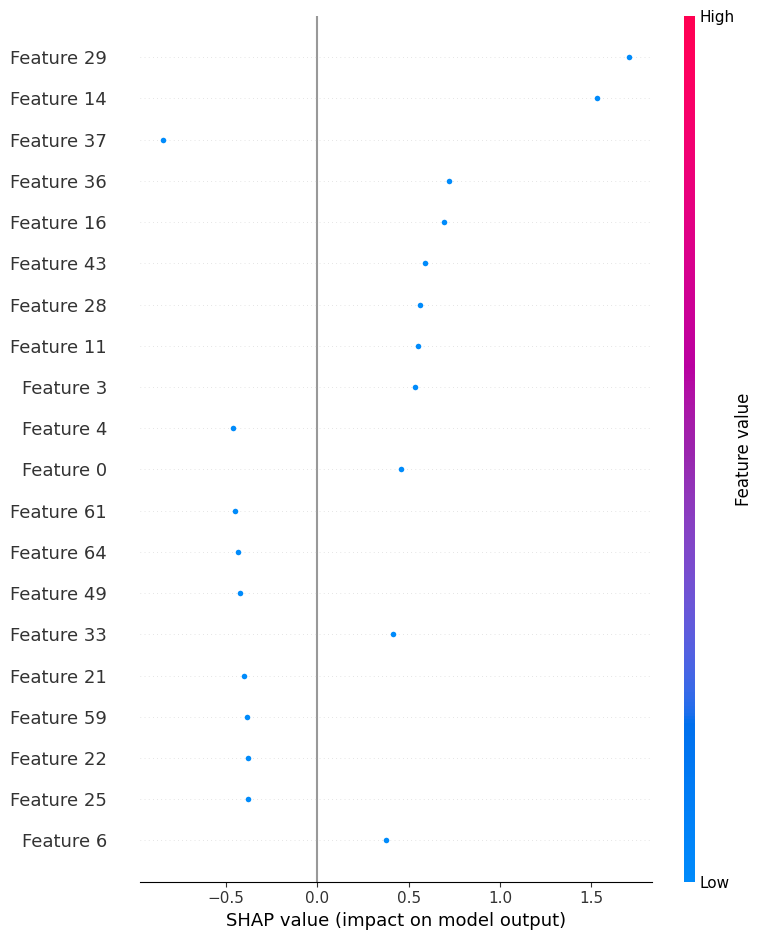

In [ ]:
# Select the first text sample as an example
train_sample_data_single = np.expand_dims(train_sample_data[0], axis=0)  # Use only the first sample

# Set the background data with a subset of 10 samples (already likely in 2D)
train_sample_data_subset = np.array(train_sample_data[:10])  # Might already be 2D

# Prepare data for SHAP analysis (using 10 samples)
background_data = shap.kmeans(train_sample_data_subset, 10)

# Set up the SHAP explainer
explainer = shap.KernelExplainer(model_predict, background_data)

# Calculate SHAP values (for a single sample)
shap_values = explainer.shap_values(train_sample_data_single)

# Visualize the SHAP values
shap.summary_plot(shap_values, train_sample_data_single)


In [ ]:
print(train_data[0])

[127043 219637 343226 215893 166429 197853 286778 202892 262320 119034
 396521 211794 219637 140176 219637 166429   8319 393198 396521  67511
 330867 191261 219637 322220 252681 227248 219637   8319  79413 125295
 363528 275261 219637 277286 388327 219637  45433 219000 119034  74363
    502 353173 306483 206713 196917  91296 412741 133182 414280 258965
  12482 195416 275260 266926  74363 122434 215882 153791 206713 239486
 377133 297784 166429 271631 266926 197853 195416  39978 226618  38677
  74363 133609 206713 269815 202892 329792 120536   9458 284060 274715
 206713 197853 273328 202892 303530 202892 197853 227437 295035 415635
 137577 364852  39246 224525 266926  74363 145681 408659 357318 122865]


In [ ]:
# Create reverse_vocab to map index to word
reverse_vocab = {index: word for word, index in vocab.items()}

# Function to convert encoded text to words
def decode_text(encoded_text, reverse_vocab):
    return [reverse_vocab.get(index, "<UNK>") for index in encoded_text]

# Decode the first text (train_data[0]) as an example
train_sample = train_data['padded'].iloc[0]  # First sample (padded)

# Convert train_sample to words
decoded_sample = decode_text(train_sample, reverse_vocab)

# Print the result
print("Decoded Text for train_data[0]:", " ".join(decoded_sample))


Decoded Text for train_data[0]: elon musk ’ s tesla stock up $ 2 billion since joining trump ’ s teamalthough tesla ceo elon musk shocked silicon valley by breaking ranks to become an official member of the white house manufacturing jobs initiative , the value of his tesla stock is up by over $ 2 billion since the election of donald trump as president . [ after a dizzying week of executive orders covering obamacare , trade and immigration , president trump held an approval rating of 55 percent of likely voters according to the rasmussen reports daily presidential tracking poll . that is


In [ ]:
# Check the Words for Features
feature_29_word = decoded_sample[29]  # Feature 29
feature_14_word = decoded_sample[14]  # Feature 14
feature_37_word = decoded_sample[37]  # Feature 37
feature_36_word = decoded_sample[36]  # Feature 36
feature_16_word = decoded_sample[16]  # Feature 16

print(f"Feature 29 corresponds to the word: {feature_29_word}")
print(f"Feature 14 corresponds to the word: {feature_14_word}")
print(f"Feature 37 corresponds to the word: {feature_37_word}")
print(f"Feature 36 corresponds to the word: {feature_36_word}")
print(f"Feature 16 corresponds to the word: {feature_16_word}")

Feature 29 corresponds to the word: official
Feature 14 corresponds to the word: s
Feature 37 corresponds to the word: initiative
Feature 36 corresponds to the word: jobs
Feature 16 corresponds to the word: tesla
